## Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

## Load the Data and view basic statistics

In [2]:
df = pd.read_csv("/content/insurance_claims.csv",index_col=0)

# Display initial rows, data types, and summary statistics
initial_rows = df.head()
data_types = df.dtypes
summary_statistics = df.describe()

df.head(), data_types, summary_statistics

(                    age  policy_number policy_bind_date policy_state  \
 months_as_customer                                                     
 328                  48         521585       2014-10-17           OH   
 228                  42         342868       2006-06-27           IN   
 134                  29         687698       2000-09-06           OH   
 256                  41         227811       1990-05-25           IL   
 228                  44         367455       2014-06-06           IL   
 
                    policy_csl  policy_deductable  policy_annual_premium  \
 months_as_customer                                                        
 328                   250/500               1000                1406.91   
 228                   250/500               2000                1197.22   
 134                   100/300               2000                1413.14   
 256                   250/500               2000                1415.74   
 228                  500/1000 

#Data Preprocessing


## 1. Handling Missing values

In [3]:
# 1. Handling missing values
# Counting missing values in each column
missing_values = df.isnull().sum()

# Columns with '?' might also indicate missing values, so checking for them
columns_with_question_mark = df.apply(lambda x: (x == '?').sum())

# Handling missing values
# For simplicity, replacing '?' with NaN and then handling them
df.replace('?', pd.NA, inplace=True)

# Imputing missing values for categorical columns with the mode
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df.mode().iloc[0])

# Dropping the column '_c39' as it seems to be irrelevant (entirely NaN)
df.drop(columns=['_c39'], inplace=True)

## 2. Identifying and handling outliers

In [4]:
# 2. Identifying and handling outliers
# For simplicity, considering numerical columns for outlier detection
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
outlier_bounds = df[numerical_cols].quantile([0.01, 0.99])

# Clipping the outliers
for col in numerical_cols:
    lower_bound = outlier_bounds.loc[0.01, col]
    upper_bound = outlier_bounds.loc[0.99, col]
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

## 3. Normalizing or standardizing features

In [5]:
# 3. Normalizing or standardizing features if necessary
# Normalizing numerical columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Displaying the updated dataset
df.head(), missing_values, columns_with_question_mark


(                         age  policy_number policy_bind_date policy_state  \
 months_as_customer                                                          
 328                 0.657895       0.467104       2014-10-17           OH   
 228                 0.500000       0.264220       2006-06-27           IN   
 134                 0.157895       0.655680       2000-09-06           OH   
 256                 0.473684       0.133604       1990-05-25           IL   
 228                 0.552632       0.292132       2014-06-06           IL   
 
                    policy_csl  policy_deductable  policy_annual_premium  \
 months_as_customer                                                        
 328                   250/500           0.333333               0.615630   
 228                   250/500           1.000000               0.434496   
 134                   100/300           1.000000               0.621012   
 256                   250/500           1.000000               0.623258

## 4. Data Transformation

In [6]:
# Data Transformation: Convert dates to datetime and extract year, month, day
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])

df['policy_bind_year'] = df['policy_bind_date'].dt.year
df['policy_bind_month'] = df['policy_bind_date'].dt.month
df['policy_bind_day'] = df['policy_bind_date'].dt.day

df['incident_year'] = df['incident_date'].dt.year
df['incident_month'] = df['incident_date'].dt.month
df['incident_day'] = df['incident_date'].dt.day

# Drop original date columns
df=df.drop(['policy_bind_date', 'incident_date'], axis=1)

df.dtypes

age                            float64
policy_number                  float64
policy_state                    object
policy_csl                      object
policy_deductable              float64
policy_annual_premium          float64
umbrella_limit                 float64
insured_zip                    float64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                  float64
capital-loss                   float64
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_location               object
incident_hour_of_the_day       float64
number_of_vehicles_involved    float64
property_damage                 object
bodily_injuries          

## 5. Encoding Categorical Features

In [7]:
# Encoding Categorical Features: One-hot encoding for categorical variables
categorical_features = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)


## 6. Standardizing Numerical Features

In [8]:
# Standardizing Numerical Features: Apply scaling to numerical columns
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df.head()

,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,...,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,fraud_reported_Y
months_as_customer,,,,,,,,,,,,,,,,,,,,,
328,0.998198,-0.095984,-0.222383,0.626664,-0.482461,-0.489594,1.020298,0.956681,-0.956261,-0.823865,...,0,0,0,0,0,0,0,0,0,1
228,0.336117,-0.791936,1.412784,-0.248564,1.724588,-0.461068,-0.904835,0.956681,-0.524475,-0.823865,...,0,0,0,0,0,0,0,0,0,1
134,-1.098393,0.550887,1.412784,0.652667,1.724588,-0.981941,0.362935,0.956681,-0.668404,1.140056,...,1,0,0,0,0,0,0,0,0,0
256,0.225770,-1.239985,1.412784,0.663520,2.165997,1.491911,0.861375,-1.276678,-0.956261,-0.823865,...,0,0,0,0,1,0,0,0,0,1
228,0.556810,-0.696190,-0.222383,1.365447,2.165997,1.528042,1.479007,-0.689705,1.202666,-0.823865,...,0,1,0,0,0,0,0,0,0,0


# Exploratory Data Analysis (EDA)

We use various visualizations to gain insights into our data. Let's take a look at some of these.

This pairplot shows relationships between key numerical variables. It helps us understand correlations and potential patterns in the dataset.

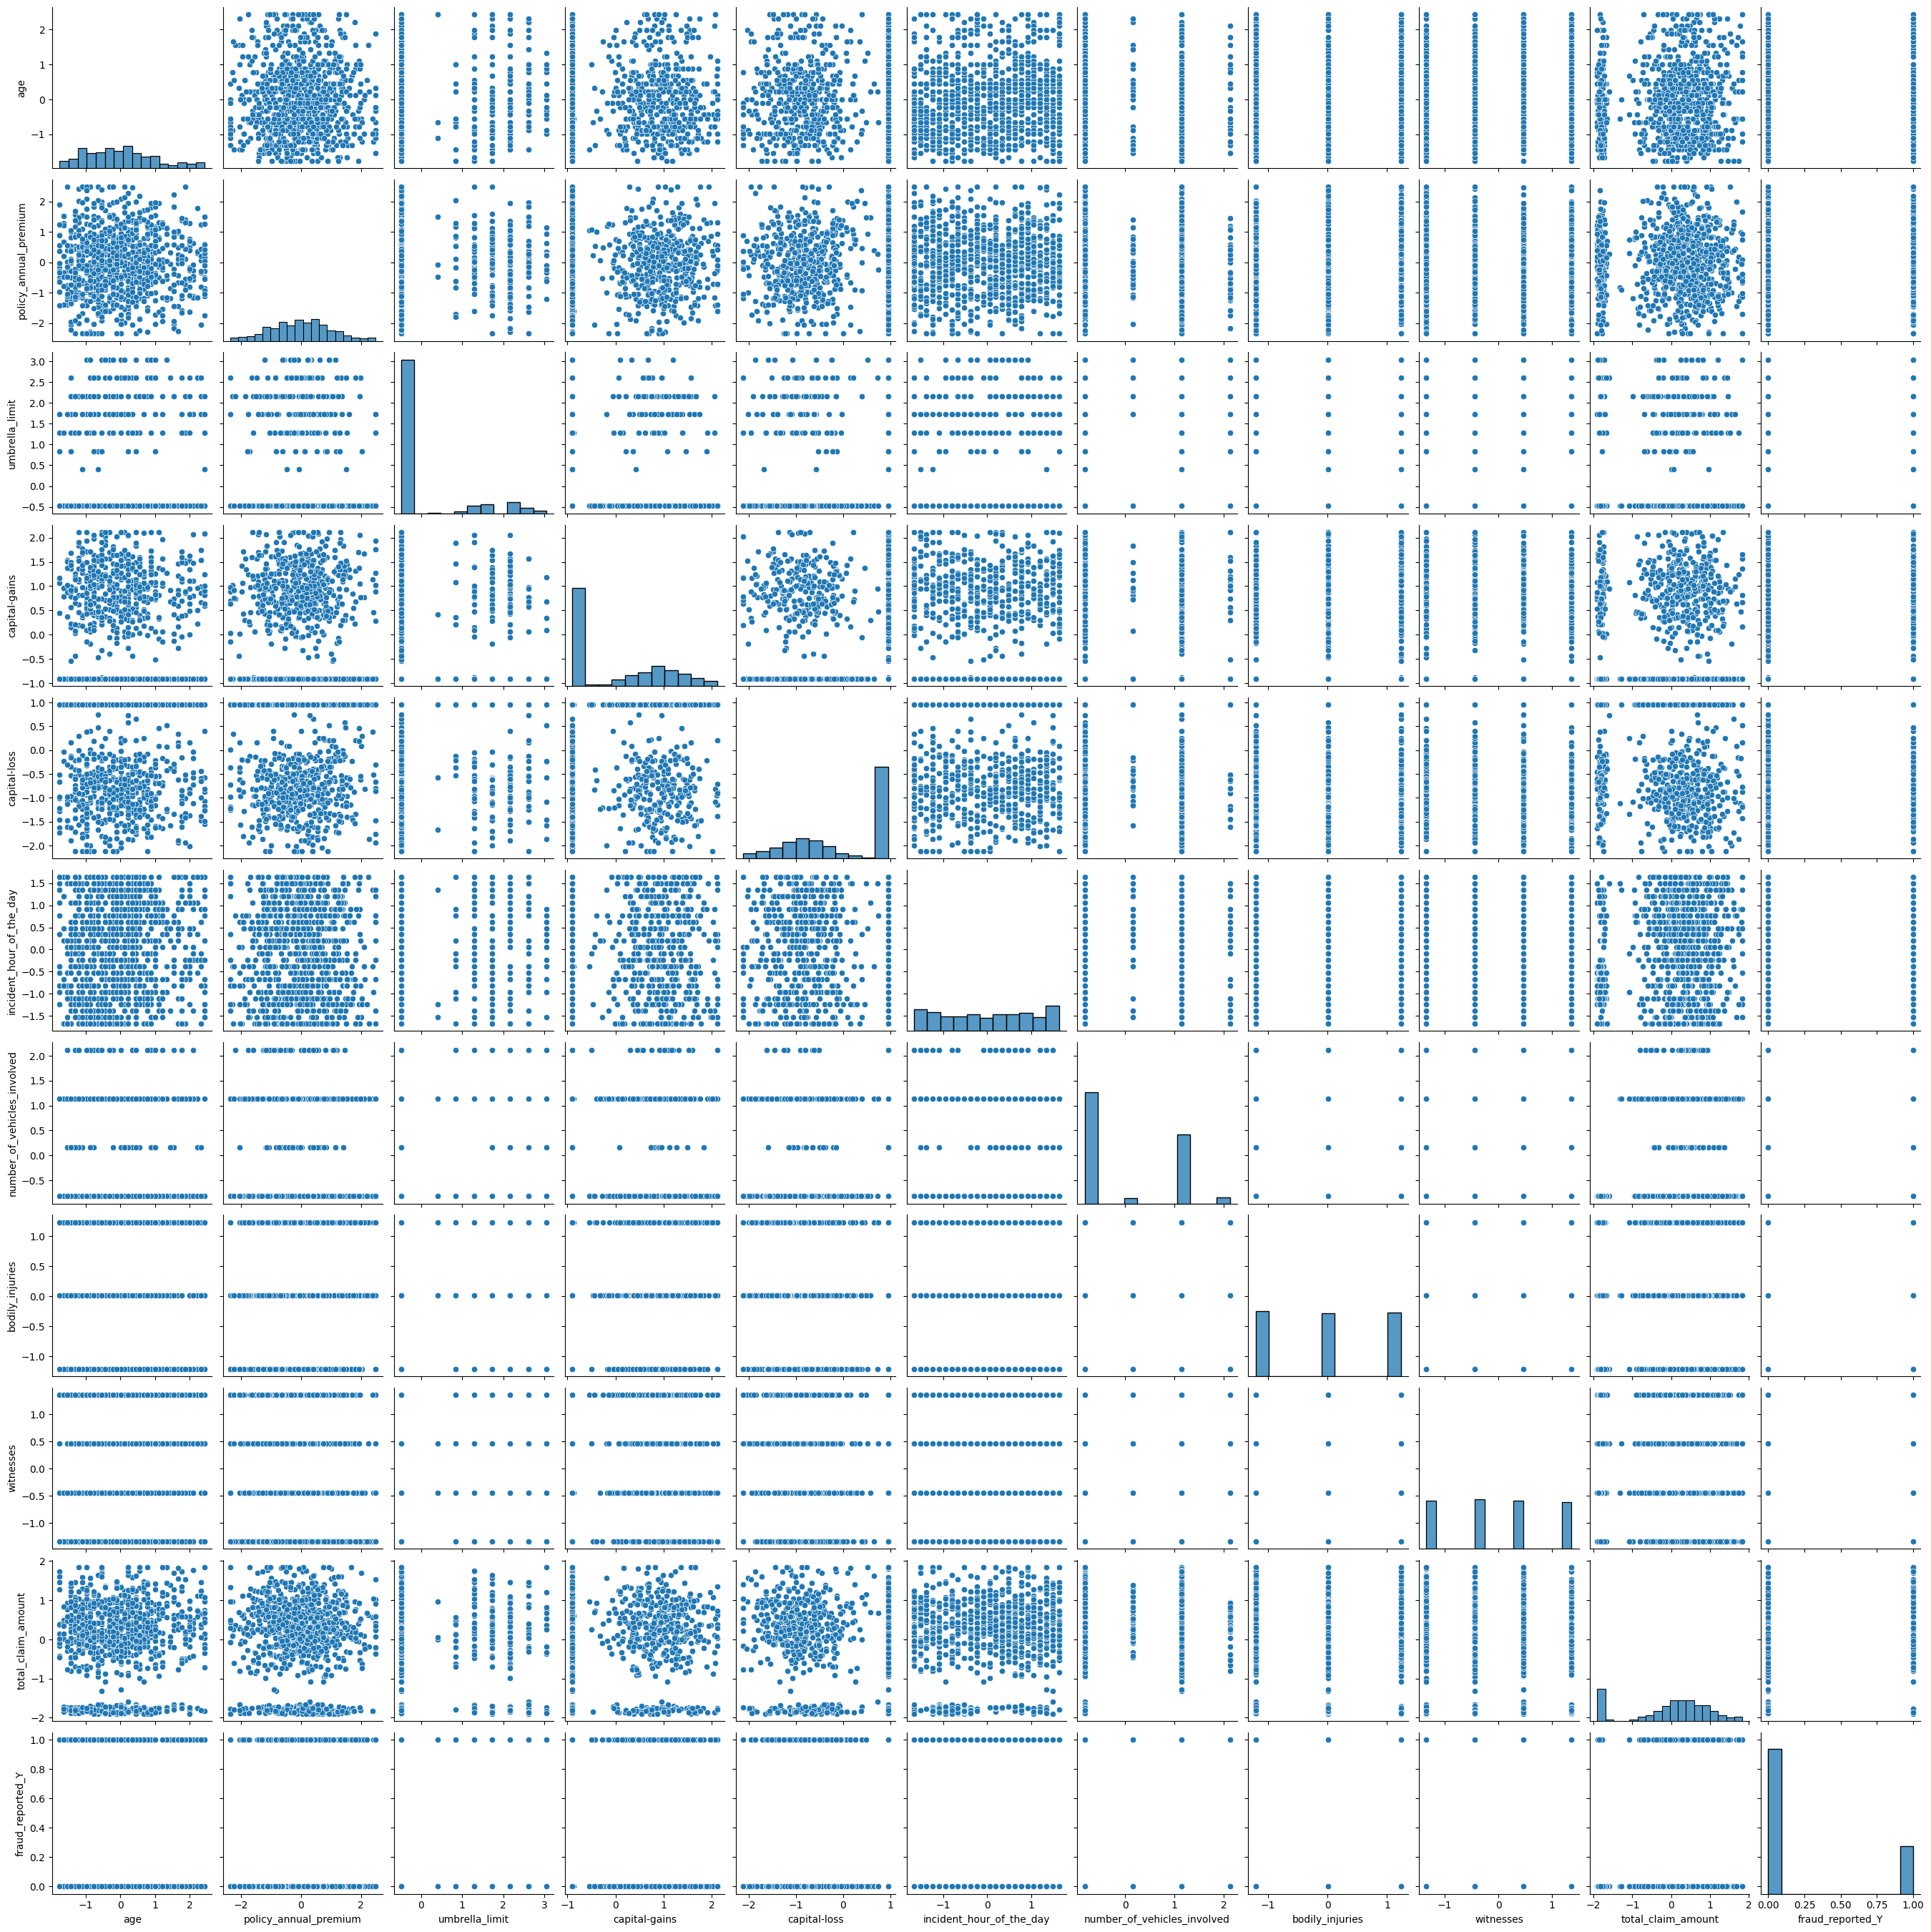

In [9]:
# Performing a more detailed Exploratory Data Analysis (EDA) on key aspects of the insurance claims dataset

# Selecting a few key columns for deeper EDA
selected_columns = ['age', 'policy_annual_premium', 'umbrella_limit', 'capital-gains', 'capital-loss',
                    'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries',
                    'witnesses', 'total_claim_amount','fraud_reported_Y']

# Creating a smaller dataframe with the selected columns
selected_data = df[selected_columns]

# Pairplot to visualize relationships between key numerical variables
sns.pairplot(selected_data)
plt.show()

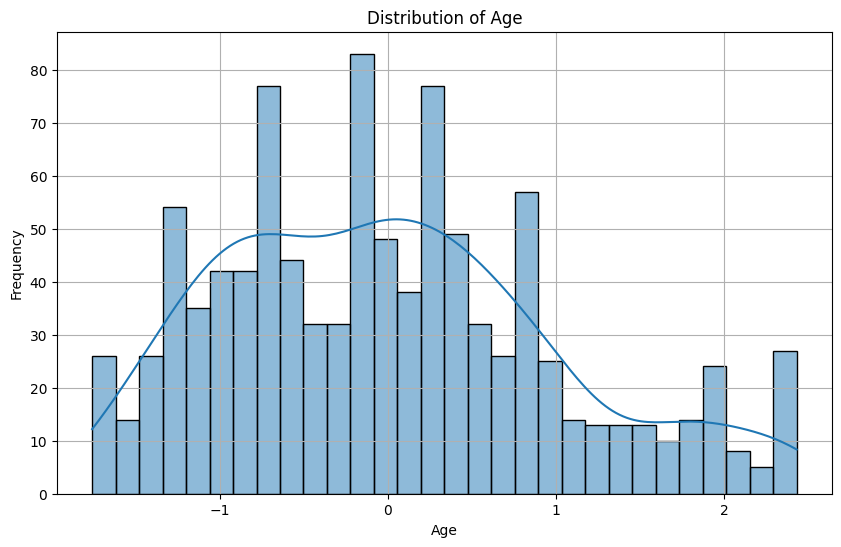

In [10]:
# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], kde=True, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This count plot represents the number of vehicles involved in incidents. Such data helps us identify common scenarios in insurance claims.

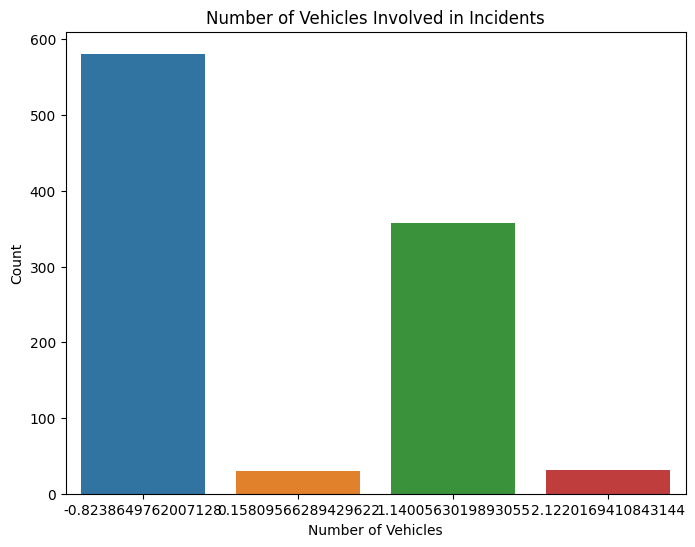

In [11]:
# Count plot for number of vehicles involved in incidents
plt.figure(figsize=(8, 6))
sns.countplot(data=selected_data, x='number_of_vehicles_involved')
plt.title('Number of Vehicles Involved in Incidents')
plt.xlabel('Number of Vehicles')
plt.ylabel('Count')
plt.show()

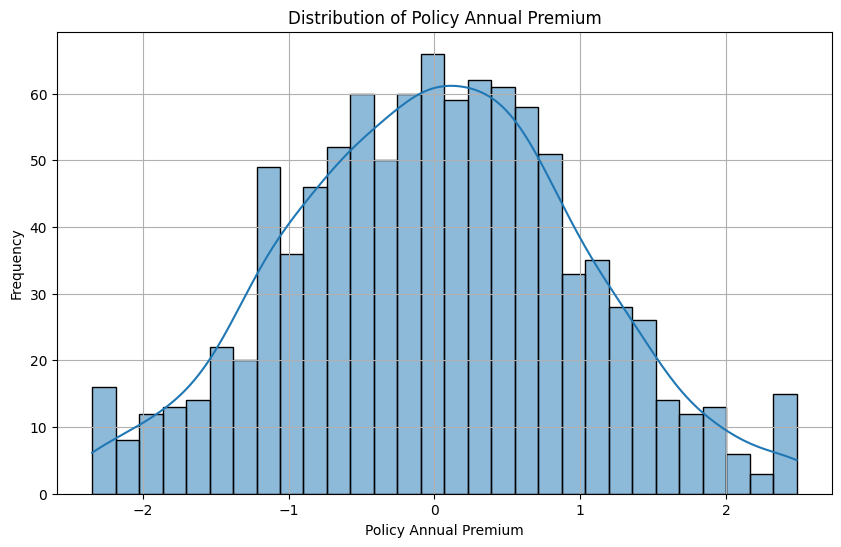

In [12]:
# Distribution of Policy Annual Premium
plt.figure(figsize=(10, 6))
sns.histplot(df['policy_annual_premium'], kde=True, bins=30)
plt.title('Distribution of Policy Annual Premium')
plt.xlabel('Policy Annual Premium')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

And here's a heatmap showing the correlation matrix for selected features. It highlights how different variables are related, aiding in feature selection.

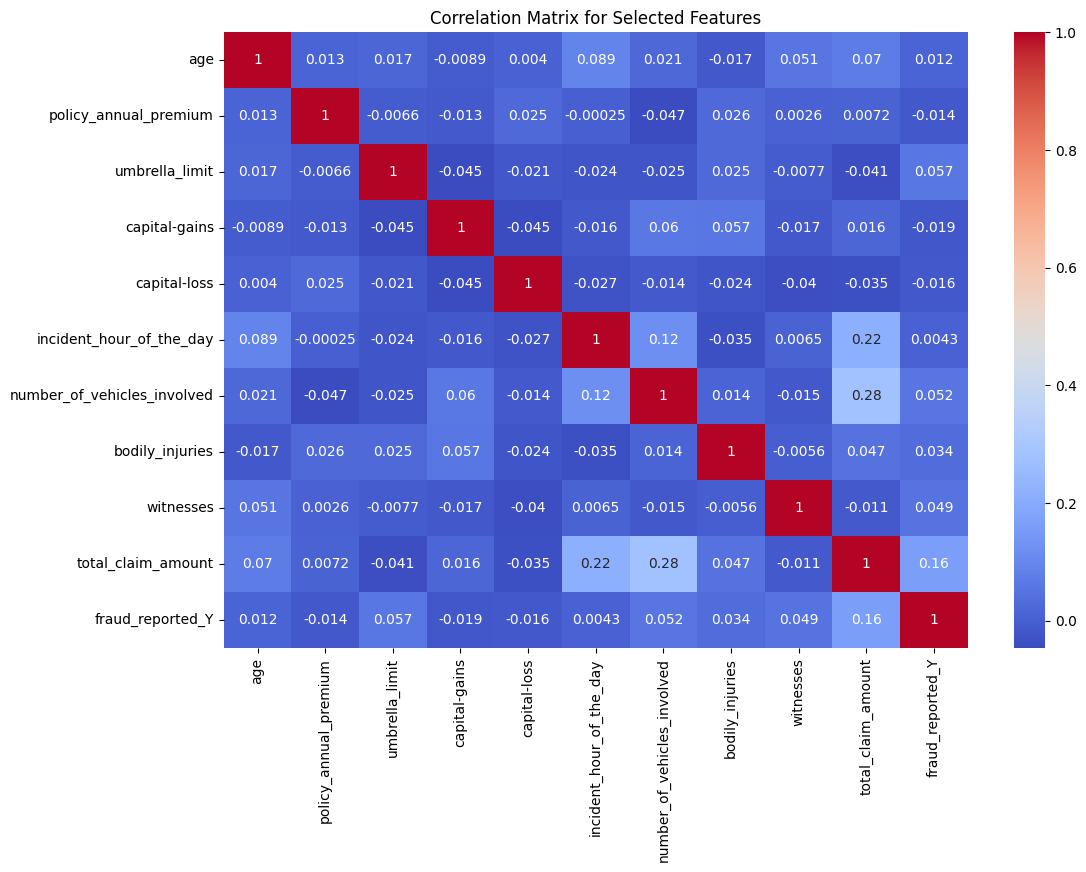

In [13]:
# Correlation heatmap for the selected data
plt.figure(figsize=(12, 8))
sns.heatmap(selected_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Selected Features')
plt.show()

# Machine Learning Modeling

Now, let's dive into the machine learning modeling. We used a combination of Support Vector Machine, Random Forest Classifier, and a Voting Classifier. These models were chosen for their ability to handle complex datasets and provide robust predictions.

We handled class imbalance with SMOTE, ensuring our model's performance is not biased.

In [14]:
# Splitting the dataset into features and target variable
X = df.drop('fraud_reported_Y', axis=1)
y = df['fraud_reported_Y']

# Handling class imbalance with SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)


Here, we can see the implementation of our models.

In [15]:
# Implementing machine learning models
# Support Vector Machine
svm_model = SVC(class_weight='balanced', probability=True)

# Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced')

# Creating a Voting Classifier with SVM and Random Forest
voting_clf = VotingClassifier(estimators=[('svm', svm_model), ('rf', rf_model)], voting='soft')

# Training the models
svm_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(class_weight='balanced', probability=True)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced'))],
                 voting='soft')

In [16]:
# Making predictions
svm_predictions = svm_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
voting_predictions = voting_clf.predict(X_test)

After training, we evaluated our models using various metrics like accuracy, precision, recall, and the F1 score. The Voting Classifier, combining SVM and Random Forest, emerged as the top performer, effectively identifying fraudulent claims with higher accuracy.

In [17]:
# Function to calculate evaluation metrics and plot ROC curve
def evaluate_model(y_true, y_pred, model_name, X_test, y_test, model):
    # Calculating metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return precision, recall, f1, roc_auc, conf_matrix


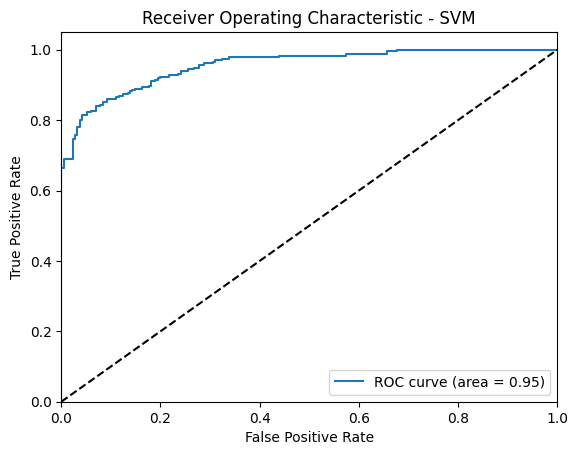

In [18]:
# Evaluating SVM model
svm_precision, svm_recall, svm_f1, svm_roc_auc, svm_conf_matrix = evaluate_model(y_test, svm_predictions, "SVM", X_test, y_test, svm_model)

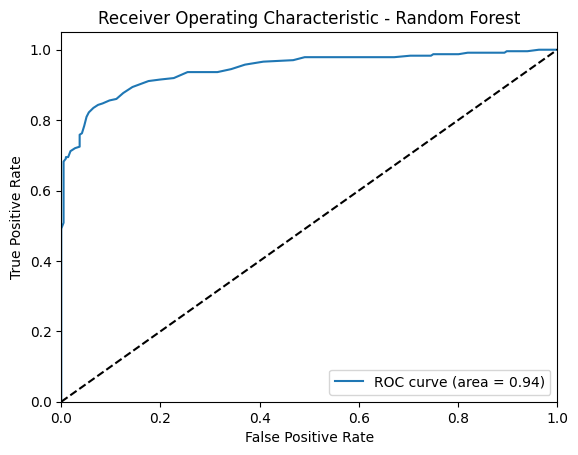

In [19]:
# Evaluating RandomForest model
rf_precision, rf_recall, rf_f1, rf_roc_auc, rf_conf_matrix = evaluate_model(y_test, rf_predictions, "Random Forest", X_test, y_test, rf_model)

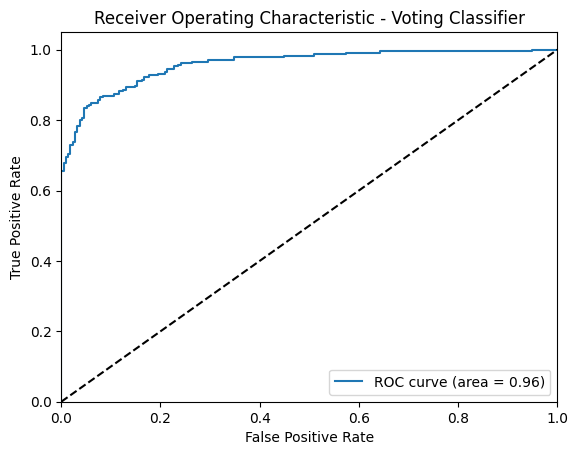

In [20]:
# Evaluating Voting Classifier model
voting_precision, voting_recall, voting_f1, voting_roc_auc, voting_conf_matrix = evaluate_model(y_test, voting_predictions, "Voting Classifier", X_test, y_test, voting_clf)

In [21]:
svm_report = classification_report(y_test, svm_predictions)
rf_report = classification_report(y_test, rf_predictions)
voting_report = classification_report(y_test, voting_predictions)

In [22]:
(svm_report, rf_report, voting_report)

('              precision    recall  f1-score   support\n\n           0       0.79      0.97      0.87       216\n           1       0.96      0.76      0.85       236\n\n    accuracy                           0.86       452\n   macro avg       0.88      0.87      0.86       452\nweighted avg       0.88      0.86      0.86       452\n',
 '              precision    recall  f1-score   support\n\n           0       0.83      0.94      0.88       216\n           1       0.94      0.82      0.88       236\n\n    accuracy                           0.88       452\n   macro avg       0.89      0.88      0.88       452\nweighted avg       0.89      0.88      0.88       452\n',
 '              precision    recall  f1-score   support\n\n           0       0.84      0.95      0.89       216\n           1       0.95      0.83      0.89       236\n\n    accuracy                           0.89       452\n   macro avg       0.89      0.89      0.89       452\nweighted avg       0.90      0.89      0.

# Summary:

*   The Voting Classifier seems to perform the best among the three models, achieving the highest accuracy and a good balance between precision and recall.
*   The RandomForest model also shows a strong balance between precision and recall with slightly lower accuracy than the Voting Classifier.
*   The SVM model, while having high precision for class 1, shows a lower recall for this class, indicating it might miss more true positive cases.





